In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import gym

from gym import spaces

# import axelrod

In [2]:
import ray
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.ppo import DEFAULT_CONFIG as DEFAULT_CONFIG_PPO

from ray.rllib.agents.dqn import DQNTrainer, DEFAULT_CONFIG 
from ray.rllib.agents.dqn import  DEFAULT_CONFIG as DEFAULT_CONFIG_DQN


from ray.tune.registry import register_env
from ray.tune.logger import pretty_print
from ray import tune

ray.init(ignore_reinit_error=True, log_to_driver=False)

/home/peter/.local/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(
2021-08-14 17:00:11,242	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.1.21',
 'raylet_ip_address': '192.168.1.21',
 'redis_address': '192.168.1.21:56669',
 'object_store_address': '/tmp/ray/session_2021-08-14_17-00-09_290815_30838/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-08-14_17-00-09_290815_30838/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-08-14_17-00-09_290815_30838',
 'metrics_export_port': 61813,
 'node_id': 'd4e986a162862711e7bfacdb06e2a905e1e5799bd1724016241e2243'}

In [3]:
DEFAULT_CONFIG_DQN

{'num_workers': 0,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 4,
 'batch_mode': 'truncate_episodes',
 'train_batch_size': 32,
 'model': {'_use_default_native_models': False,
  'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,
  'attention_use_n_prev_actions': 0,
  'attention_use_n_prev_rewards': 0

In [7]:
class MatrixGame():
    
    def __init__(self, RPST=(3,1,0,5)):
        
        self.RPST = RPST
        
        self.payoff_mat = np.empty((2,2), dtype=np.object)
        
        self.payoff_mat[0, 0] = (RPST[0], RPST[0])
        self.payoff_mat[1, 1] = (RPST[1], RPST[1])
        self.payoff_mat[0, 1] = (RPST[2], RPST[3])
        self.payoff_mat[1, 0] = (RPST[3], RPST[2])
        
    def play(self, a_row, a_col):
        # for ease of things 0 is coooperate
#                            1 is defect
        
        
#         if a_row == 'c':
#             row = 0
#         else:
#             row = 1
            
#         if a_col == 'c':
#             col = 0
#         else:
#             col = 1
            
        return self.payoff_mat[a_row, a_col]
        

In [8]:
class TitForTatPlayer():
    """Starts by cooperating, and then always plays the opponents previous move
    
    """
    
    def __init__(self):
        
        self.count = 0
        self.opponents_move = 0
        
    def play(self):
        
        return self.opponents_move
    
    def update(self, opponents_move):
        self.opponents_move = opponents_move
        
    def reset(self):
        
        self.count = 0
        self.opponents_move = 0
 

In [9]:
class TitForTatThenDefectPlayer():
    """Starts by cooperating, and then always plays the opponents previous move
    
    """
    
    def __init__(self, n_defect_turn=50):
        
        self.count = 0
        self.opponents_move = 0
        self.n_defect_turn = n_defect_turn
        
    def play(self):
        
        if self.count < self.n_defect_turn:
            return self.opponents_move
        else:
            return 1
    
    def update(self, opponents_move):
        
        self.opponents_move = opponents_move
        self.count += 1
        
        
    def reset(self):
        
        self.count = 0
        self.opponents_move = 0
 

In [10]:
np.random.randint(2, dtype=np.bool)

False

In [11]:
class TitForTatOrRandom():
    """Starts by cooperating, and then always plays the opponents previous move
    
    """
    
    def __init__(self):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)
        
    def play(self):
        
        if self.is_random:
            return np.random.randint(2)
        else:
            return self.opponents_move
    
    def update(self, opponents_move):
        
        self.opponents_move = opponents_move
        self.count += 1
        
        
    def reset(self):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)

 

In [12]:
class TitForTatOrDefect():
    """Starts by cooperating, and then always plays the opponents previous move
    
    """
    
    def __init__(self):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)
        
    def play(self):
        
        if self.is_random:
            return 1
        else:
            return self.opponents_move
    
    def update(self, opponents_move):
        
        self.opponents_move = opponents_move
        self.count += 1
        
        
    def reset(self):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)

 

In [13]:
class TitForTatThenDefectPlayer():
    """Starts by cooperating, and then always plays the opponents previous move
    
    """
    
    def __init__(self, min_defect_turn = 50, max_defect_turn=100):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)
        self.min_defect_turn = min_defect_turn
        self.max_defect_turn = max_defect_turn
        
        self.defect_turn = np.random.randint(low=self.min_defect_turn, high=self.max_defect_turn)
        
    def play(self):
        
        if self.count > self.defect_turn:
            return 1
        else:
            return self.opponents_move
    
    def update(self, opponents_move):
        
        self.opponents_move = opponents_move
        self.count += 1
        
        
    def reset(self):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)
        self.defect_turn = np.random.randint(low=self.min_defect_turn, high=self.max_defect_turn)

 

In [14]:
class GrudgePlayer():
    """Starts by cooperating, but defects forever if opponent defects
    
    """
    
    def __init__(self):
        
        self.count = 0
#         self.opponents_move = 0
        self.grudging = False # has the opponent played defect
        
    def play(self):
        
        if self.grudging:
            return 1
        
        else:
            return 0
    
    def update(self, opponents_move):
#         self.opponents_move = opponents_move
        if opponents_move == 1:
            self.grudging = True
        
    def reset(self):
        
        self.count = 0
        self.grudging = False  

In [15]:
class RandomPlayer():
    """Cooperates a with a fixed probability
    
    """
    
    def __init__(self, P_coop=0.5):
        
        self.count = 0
        self.P_coop = P_coop
        
        assert self.P_coop <= 1.
    
        
    def play(self):
        
        if np.random.rand() < self.P_coop:
            return 0 
        
        else:
            return 1
        
    
    def update(self, opponents_move):
        pass
        
    def reset(self):
        
        self.count = 0


In [16]:
class RandomProbPlayer():
    """Cooperates a with a probability P_coop,
    P_coop is chosen randomly each round
    
    """
    
    def __init__(self):
        
        self.count = 0
        self.P_coop = np.random.rand()
            
        
    def play(self):
        
        if np.random.rand() < self.P_coop:
            return 0 
        
        else:
            return 1
        
    
    def update(self, opponents_move):
        pass
        
    def reset(self):
        
        self.count = 0
        self.P_coop = np.random.rand()



In [17]:
class CooperateOrDefectPlayer():
    """Either always cooperates or always defects each round
    
    """
    
    def __init__(self):
        
        self.count = 0
        self.P_coop = np.random.randint(2)
            
        
    def play(self):
        
        if np.random.rand() < self.P_coop:
            return 0 
        
        else:
            return 1
        
    
    def update(self, opponents_move):
        pass
        
    def reset(self):
        
        self.count = 0
        self.P_coop = np.random.randint(2)



In [18]:
class CooperatePlayer(RandomPlayer):
    """ Always cooperates
    """
    def __init__(self):
        super().__init__(P_coop=1.)

In [19]:
class DefectPlayer(RandomPlayer):
    """Always defects
    """
     
    def __init__(self):
        super().__init__(P_coop=0.)

In [20]:
class MatrixGameFlipEnv(gym.Env):
    
    def __init__(self,  RPST=(3,1,0,5), history_n=100, player2=TitForTatPlayer()):
        
        self.RPST = RPST
        self.history_n = history_n
        self.history = np.zeros((2,2,self.history_n))
        self._counter = 0
        self._setup_spaces()
#         self.player2 = TitForTatPlayer()
#         self.player2 = GrudgePlayer()
#         self.player2 = DefectPlayer()
#         self.player2 = CooperateOrDefectPlayer()
#         self.player2 = TitForTatThenDefectPlayer()
#         self.player2 = TitForTatOrDefect()
        self.player2 = player2
        self.game = MatrixGame(RPST=(3,1,0,5))
        
        
        
    def _setup_spaces(self):
        
        self.action_space = spaces.Discrete(2)
        
        self.observation_space = spaces.Box(0, 1,
                                           shape=(self.history_n * 4,))
        
    def history_to_state(self, history=None):
        
        if history is None:
            history = self.history
            
        state = history.flatten()
        
        return state

    def step(self, action):
        
        assert self.action_space.contains(action)
        
        action2 = self.player2.play()
        rewards = self.game.play(action, action2)
        
        self.player2.update(action)
        self.history[0, action, self._counter] = 1
        self.history[1, action2, self._counter] = 1
        
        self.state = self.history_to_state(self.history)
        
        self._counter += 1
        done = self._counter >= self.history_n 
        
        return self.state, rewards[0], done, {}

        
        
    def reset(self):

        self.history = np.zeros((2,2,self.history_n))
        self.state = self.history.flatten()

        self._counter = 0
        self.player2.reset()
        
        return self.state

        
        

In [21]:
class MatrixGameEnv(gym.Env):
    
    def __init__(self,  RPST=(3,1,0,5), history_n=100, player2=TitForTatPlayer()):
        
        self.RPST = RPST
        self.history_n = history_n
        self.history = np.zeros((2,2,self.history_n))
        self._counter = 0
        self._setup_spaces()
#         self.player2 = TitForTatPlayer()
#         self.player2 = GrudgePlayer()
#         self.player2 = DefectPlayer()
#         self.player2 = CooperateOrDefectPlayer()
#         self.player2 = TitForTatThenDefectPlayer()
#         self.player2 = TitForTatOrDefect()
        self.player2 = player2
        self.game = MatrixGame(RPST=(3,1,0,5))
        
        
        
    def _setup_spaces(self):
        
        self.action_space = spaces.Discrete(2)
        
        self.observation_space = spaces.Box(0, 1,
                                           shape=(self.history_n * 4,))
        
    def history_to_state(self, history=None):
        
        if history is None:
            history = self.history
            
        state = history.flatten()
        
        return state

    def step(self, action):
        
        assert self.action_space.contains(action)
        
        action2 = self.player2.play()
        rewards = self.game.play(action, action2)
        
        self.player2.update(action)
        self.history[0, action, self._counter] = 1
        self.history[1, action2, self._counter] = 1
        
        self.state = self.history_to_state(self.history)
        
        self._counter += 1
        done = self._counter >= self.history_n 
        
        return self.state, rewards[0], done, {}

        
        
    def reset(self):

        self.history = np.zeros((2,2,self.history_n))
        self.state = self.history.flatten()

        self._counter = 0
        self.player2.reset()
        
        return self.state

        
        

In [22]:
class MatrixGameRollingHistoryEnv(gym.Env):
    
    def __init__(self,  RPST=(3,1,0,5), history_n=10, game_length=100,player2=TitForTatPlayer()):
        
        self.RPST = RPST
        self.history_n = history_n
        self.game_length = game_length
        self.history = np.zeros((2,2,self.history_n))
        self._counter = 0
        self._setup_spaces()
#         self.player2 = TitForTatPlayer()
#         self.player2 = GrudgePlayer()
#         self.player2 = DefectPlayer()
#         self.player2 = CooperateOrDefectPlayer()
#         self.player2 = TitForTatThenDefectPlayer()
#         self.player2 = TitForTatOrDefect()
        self.player2 = player2
        self.game = MatrixGame(RPST=RPST)
        
        
        
    def _setup_spaces(self):
        
        self.action_space = spaces.Discrete(2)
        
        self.observation_space = spaces.Box(0, 1,
                                           shape=(self.history_n * 4,))
        
    def history_to_state(self, history=None):
        
        if history is None:
            history = self.history
            
        state = history.flatten()
        
        return state
    
    def update_history(self, action1, action2):
        
#         if self._counter < self.history_n:
#             self.history[0, action, self._counter] = 1
#             self.history[1, action2, self._counter] = 1
#         else:
        self.history[:,:,:-1] = self.history[:,:,1:]
        self.history[:,:,-1] = 0
        self.history[0, action1, -1] = 1
        self.history[1, action2, -1] = 1
        

    def step(self, action):
        
        assert self.action_space.contains(action)
        
        action2 = self.player2.play()
        rewards = self.game.play(action, action2)
        
        self.player2.update(action)
        

        
        self.update_history(action, action2)
        
        self.state = self.history_to_state(self.history)
        self._counter += 1
        
        done = self._counter >= self.game_length

        return self.state, rewards[0], done, {}

        
        
    def reset(self):

        self.history = np.zeros((2,2,self.history_n))
        self.state = self.history.flatten()

        self._counter = 0
        self.player2.reset()
        
        return self.state

        
        

In [23]:
class MatrixGameRollingHistoryEnv_2player(gym.Env):
    
    def __init__(self,  RPST=(3,1,0,5), history_n=10, game_length=100):
        
        self.RPST = RPST
        self.history_n = history_n
        self.game_length = game_length
        self.history = np.zeros((2,2,self.history_n))
        self._counter = 0
        self._setup_spaces()
#         self.player2 = TitForTatPlayer()
#         self.player2 = GrudgePlayer()
#         self.player2 = DefectPlayer()
#         self.player2 = CooperateOrDefectPlayer()
#         self.player2 = TitForTatThenDefectPlayer()
#         self.player2 = TitForTatOrDefect()
        self.game = MatrixGame(RPST=RPST)
        
        
        
    def _setup_spaces(self):
        
        self.action_space = spaces.Discrete(2)
        
        self.observation_space = spaces.Box(0, 1,
                                           shape=(self.history_n * 4,))
        
    def history_to_state(self, history=None):
        
        if history is None:
            history = self.history
            
        state = history.flatten()
        
        return state
    
    def update_history(self, action1, action2):
        
#         if self._counter < self.history_n:
#             self.history[0, action, self._counter] = 1
#             self.history[1, action2, self._counter] = 1
#         else:
        self.history[:,:,:-1] = self.history[:,:,1:]
        self.history[:,:,-1] = 0
        self.history[0, action1, -1] = 1
        self.history[1, action2, -1] = 1
        

    def step(self, action, action2):
        
        assert self.action_space.contains(action)
        
#         action2 = self.player2.play()
        rewards = self.game.play(action, action2)
                

        
        self.update_history(action, action2)
        
        self.state = self.history_to_state(self.history)
        self._counter += 1
        
        done = self._counter >= self.game_length

        return self.state, rewards[0], done, {}

        
        
    def reset(self):

        self.history = np.zeros((2,2,self.history_n))
        self.state = self.history.flatten()

        self._counter = 0
        
        return self.state

        
        

In [24]:
class MatrixGameEnv(gym.Env):
    
    def __init__(self,  RPST=(3,1,0,5), history_n=100, player2=TitForTatPlayer()):
        
        self.RPST = RPST
        self.history_n = history_n
        self.history = np.zeros((2,2,self.history_n))
        self._counter = 0
        self._setup_spaces()
        self.player2 = player2
        self.game = MatrixGame(RPST=RPST)
        
        
    def _setup_spaces(self):
        
        self.action_space = spaces.Discrete(2)
        
        self.observation_space = spaces.Box(0, 1,
                                           shape=(self.history_n * 4,))
        
    def history_to_state(self, history=None):
        
        if history is None:
            history = self.history
            
        state = history.flatten()
        
        return state
    
    def update_history(self, action1, action2):
        
#         if self._counter < self.history_n:
#             self.history[0, action, self._counter] = 1
#             self.history[1, action2, self._counter] = 1
#         else:
        self.history[:,:,1:] = self.history[:,:,:-1]
        self.history[:,:,0] = 0
        self.history[0, action1, 0] = 1
        self.history[1, action2, 0] = 1
        

    def step(self, action):
        
        assert self.action_space.contains(action)
        
        action2 = self.player2.play()
        rewards = self.game.play(action, action2)
        
        self.player2.update(action)
        self.update_history(action, action2)
        
        self.state = self.history_to_state(self.history)
        self._counter += 1
        
        done = self._counter >= self.history_n

        return self.state, rewards[0], done, {}

        
        
    def reset(self):

        self.history = np.zeros((2,2,self.history_n))
        self.state = self.history.flatten()

        self._counter = 0
        self.player2.reset()
        
        return self.state


In [25]:
env = MatrixGameEnv(history_n=10)

In [26]:
env.reset()

for ii in range(50):
    action = np.random.randint(2)
    print(action)
    print(ii)
    env.step(action)
    print(env.history)
    print('====')

1
0
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
====
1
1
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
====
0
2
[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]]
====
0
3
[[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]]
====
0
4
[[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]]

 [[1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]]
====
1
5
[[[0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 1. 1. 0. 0. 0. 0.]]

 [[1. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]]]
====
0
6
[[[1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]]

 [[0. 1. 1. 1. 0. 0. 1. 0. 0. 0.

In [27]:
env = MatrixGameRollingHistoryEnv(game_length)

NameError: name 'game_length' is not defined

In [28]:
# register_env("MG_roll_env", MatrixGameRollingHistoryEnv)
register_env('MG_roll_env', lambda c: MatrixGameRollingHistoryEnv(player2=TitForTatOrDefect()))

In [29]:

trainer_config_dqn = DEFAULT_CONFIG_DQN.copy()
trainer_config_dqn['num_workers'] = 3
trainer_config_dqn['n_step'] = 3
trainer_config_dqn['noisy'] = True
trainer_config_dqn['v_min'] = -10.
trainer_config_dqn['v_max'] = 10.
# trainer_config_dqn['num_atoms'] = 51

# trainer_config_dqn['model']['fcnet_hiddens'] = [1024, 512,512, 256,256,32,8]
# trainer_config_dqn['model']['fcnet_hiddens'] = tune.grid_search([[256,256,32,8],[8]])

trainer_config_dqn['model']['fcnet_hiddens'] = [256,256,32,8]
# trainer_config_dqn['lr'] = tune.grid_search([0.1,0.01,0.001,0.0001,0.00001, 0.000001])
# trainer_config_dqn['lr'] = tune.grid_search([0.1,0.0001, 0.000001])

# trainer_config_dqn['env'] = 'MG_roll_env'
# trainer_config_dqn['num_cpus_per_worker'] = 0

In [30]:
# trainer = PPOTrainer(trainer_config_ppo, env="MG_env");
trainer = DQNTrainer(trainer_config_dqn, env="MG_roll_env");
ep_min = []
ep_mean = []
ep_max = []

for i in range(0):
    print("Training iteration {}...".format(i))
    result=trainer.train()
#     print(pretty_print(result))

    print(result['episode_reward_min'])
    print(result['episode_reward_mean'])
    print(result['episode_reward_max'])
    
    ep_min.append(result['episode_reward_min'])
    ep_mean.append(result['episode_reward_mean'])
    ep_max.append(result['episode_reward_max'])

KeyboardInterrupt: 

In [42]:
env.step(1)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1.]),
 1,
 False,
 {})

In [132]:
env.reset()

for ii in range(50):
    action = np.random.randint(2)
    print(env.step(action))
    print(ii)
    print(env.history)


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]), 3, False, {})
0
[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]), 5, False, {})
1
[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0.]), 0, False, {})
2
[[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0

In [31]:
register_env('MG_env', lambda c: MatrixGameEnv(player2=TitForTatOrRandom()))

In [32]:
class MatrixGameEnv_no_history(gym.Env):
    
    def __init__(self,  RPST=(3,1,0,5), n_games=100, player2=TitForTatPlayer()):
        
        self.RPST = RPST
        self.last_moves = np.zeros((2,2))
        self._counter = 0
        self._setup_spaces()
        self.player2 = TitForTatPlayer()
#         self.player2 = GrudgePlayer()
#         self.player2 = DefectPlayer()
#         self.player2 = CooperateOrDefectPlayer()
    #         self.player2 = TitForTatThenDefectPlayer()
#         self.player2 = TitForTatOrRandom()
        self.player2 = player2
        self.n_games = n_games
        self.game = MatrixGame(RPST=(3,1,0,5))
        
        
        
    def _setup_spaces(self):
        
        self.action_space = spaces.Discrete(2)
        
        self.observation_space = spaces.Box(0, 1,
                                           shape=(4,))
        
    def lastmoves_to_state(self, last_moves=None):
        
        if last_moves is None:
            last_moves = self.last_moves
            
        state = last_moves.flatten()
        
        return state

    def step(self, action):
        
        assert self.action_space.contains(action)
        
        action2 = self.player2.play()
        rewards = self.game.play(action, action2)
        
        self.player2.update(action)
        self.last_moves = np.zeros((2,2))

        self.last_moves[0, action] = 1
        self.last_moves[1, action2] = 1
        
        self.state = self.lastmoves_to_state(self.last_moves)
        
        self._counter += 1
        done = self._counter >= self.n_games
        
        return self.state, rewards[0], done, {}

        
        
    def reset(self):

        self.last_moves = np.zeros((2,2))
        self.state = self.last_moves.flatten()

        self._counter = 0
        self.player2.reset()
        
        return self.state

        
        

In [33]:
register_env('MG_env', lambda c: MatrixGameEnv(player2=TitForTatOrDefect()))

In [34]:
trainer_config_dqn = DEFAULT_CONFIG_DQN.copy()
trainer_config_dqn['num_workers'] = 3
trainer_config_dqn['n_step'] = 3
trainer_config_dqn['noisy'] = True
trainer_config_dqn['v_min'] = -10.
trainer_config_dqn['v_max'] = 10.
# trainer_config_dqn['num_atoms'] = 51

# trainer_config_dqn['model']['fcnet_hiddens'] = [1024, 512,512, 256,256,32,8]
trainer_config_dqn['model']['fcnet_hiddens'] = [256,256,32,8]

trainer_config_dqn['num_cpus_per_worker'] = 0


In [35]:
trainer_config_ppo = DEFAULT_CONFIG_PPO.copy()
trainer_config_ppo['num_workers'] = 3
trainer_config_ppo['num_sgd_iter'] = 20
trainer_config_ppo['sgd_minibatch_size'] = 32
trainer_config_ppo['model']['fcnet_hiddens'] = [1024, 512,512, 256,256,32,8]
# trainer_config_ppo['model']['fcnet_hiddens'] = [256,256,32,8]
# trainer_config_ppo['model']['fcnet_hiddens'] = [20,20]

# trainer_config_ppo['lr'] =  0.001

trainer_config_ppo['num_cpus_per_worker'] = 0

In [24]:
# trainer = PPOTrainer(trainer_config_ppo, env="MG_env");
trainer = DQNTrainer(trainer_config_dqn, env="MG_env");
ep_min = []
ep_mean = []
ep_max = []

for i in range(20):
    print("Training iteration {}...".format(i))
    result=trainer.train()
#     print(pretty_print(result))

    print(result['episode_reward_min'])
    print(result['episode_reward_mean'])
    print(result['episode_reward_max'])
    
    ep_min.append(result['episode_reward_min'])
    ep_mean.append(result['episode_reward_mean'])
    ep_max.append(result['episode_reward_max'])

2021-08-03 19:44:40,146	INFO trainer.py:671 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-08-03 19:44:40,147	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


KeyboardInterrupt: 

In [ ]:
for i in range(50):
    print("Training iteration {}...".format(i))
    result=trainer.train()
#     print(pretty_print(result))
    
    print(result['episode_reward_min'])
    print(result['episode_reward_mean'])
    print(result['episode_reward_max'])
    
    ep_min.append(result['episode_reward_min'])
    ep_mean.append(result['episode_reward_mean'])
    ep_max.append(result['episode_reward_max'])

In [36]:
50*3+1*50

200

In [37]:
plt.plot(ep_max)
plt.plot(ep_mean)
plt.plot(ep_min)

plt.title('DQN')
plt.xlabel('20x games')
plt.legend(['max', 'mean', 'min'])

NameError: name 'ep_max' is not defined

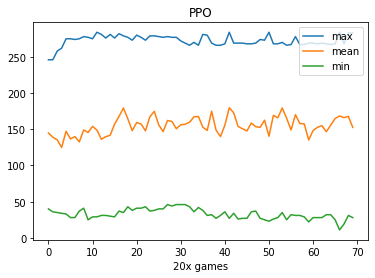

In [82]:
plt.plot(ep_max)
plt.plot(ep_mean)
plt.plot(ep_min)

plt.title('PPO')
plt.xlabel('20x games')
plt.legend(['max', 'mean', 'min'])

In [ ]:
trainer1 = PPOTrainer(trainer_config_ppo, MatrixGameEnv_no_history);
trainer2 = PPOTrainer(trainer_config_ppo, MatrixGameEnv_no_history);

# trainer = DQNTrainer(trainer_config_dqn, MatrixGameEnv_no_history);
ep_min = []
ep_mean = []
ep_max = []

for i in range(20):
    print("Training iteration {}...".format(i))
    result=trainer.train()
#     print(pretty_print(result))

    print(result['episode_reward_min'])
    print(result['episode_reward_mean'])
    print(result['episode_reward_max'])
    
    ep_min.append(result['episode_reward_min'])
    ep_mean.append(result['episode_reward_mean'])
    ep_max.append(result['episode_reward_max'])

In [41]:
state = env.reset()

done = False
cumulative_reward = 0
action_save = []
while not done:
    action = trainer.compute_action(state)
    action_save.append(action)
    state, reward, done, results = env.step(action)
    cumulative_reward += reward



In [42]:
state = env.reset()

n_samples = 50


defects = []
rewards = []
for i in range(n_samples):
    state = env.reset()
    
    total_defect = 0
    cum_reward = 0
    done = False
    while not done:
        action = trainer.compute_action(state)
        total_defect += action
        state, reward, done, results = env.step(action)
        cum_reward += reward
    defects.append(total_defect)
    rewards.append(cum_reward)

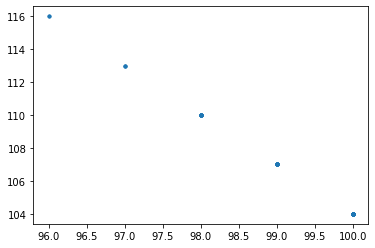

In [40]:
plt.plot(defects, rewards,'.')

In [54]:
%load_ext tensorboard

In [38]:
register_env('MG_env', lambda c: MatrixGameEnv_no_history(player2=TitForTatOrDefect()))

In [39]:
register_env('MG_t4tTR_env', lambda c: MatrixGameEnv(player2=TitForTatThenDefect()))

In [40]:
register_env('MG_roll_env', lambda c: MatrixGameRollingHistoryEnv(
    player2=TitForTatThenDefectPlayer(min_defect_turn=0, max_defect_turn=100)))

In [28]:
trainer_config_ppo = DEFAULT_CONFIG_PPO.copy()
trainer_config_ppo['num_workers'] = 3
trainer_config_ppo['num_sgd_iter'] = 20
trainer_config_ppo['sgd_minibatch_size'] = 32
# trainer_config_ppo['model']['fcnet_hiddens'] = [1024, 512,512, 256,256,32,8]
# trainer_config_ppo['model']['fcnet_hiddens'] = [256,256,32,8]
trainer_config_ppo['model']['fcnet_hiddens'] = tune.grid_search([
    [1024, 512, 256,32,8],[256,256,32,8],[256,32]])
# trainer_config_ppo['model']['fcnet_hiddens'] = tune.grid_search([[32,16], [256, 32,16], [256, 256,32,16]])
trainer_config_ppo['model']['use_lstm'] = tune.grid_search([False, True])
trainer_config_ppo['lr'] =  tune.grid_search([0.001, 0.0001, 5e-5, 1e-5])

# trainer_config_ppo['num_cpus_per_worker'] = 0
trainer_config_ppo['env'] = 'MG_roll_env'

# trainer_config_ppo['num_gpus'] = 0



In [29]:
trainer_config_ppo = DEFAULT_CONFIG_PPO.copy()


In [30]:
trainer_config_ppo = DEFAULT_CONFIG_PPO.copy()
trainer_config_ppo['num_workers'] = 3
trainer_config_ppo['num_sgd_iter'] = 20
trainer_config_ppo['sgd_minibatch_size'] = 32
# trainer_config_ppo['model']['fcnet_hiddens'] = [1024, 512,512, 256,256,32,8]
trainer_config_ppo['model']['fcnet_hiddens'] = [256,256,32,8]
# trainer_config_ppo['model']['fcnet_hiddens'] = tune.grid_search([[32,16], [256, 32,16], [256, 256,32,16]])
trainer_config_ppo['model']['use_lstm'] = False
# trainer_config_ppo['lr'] =  tune.grid_search([0.01, 0.001, 0.0001])

# trainer_config_ppo['num_cpus_per_worker'] = 0
trainer_config_ppo['env'] = 'MG_roll_env'

# trainer_config_ppo['num_gpus'] = 0



In [71]:
trainer_config_ppo['lr']

5e-05

In [ ]:
ray.init(ignore_reinit_error=True)

tune.run(
    "PPO",
    stop={"training_iteration":1000},
    name='test_cp',
    
    config=trainer_config_ppo,
#     keep_checkpoints_num=1,
#     local_dir='/home/peter/ray_results/test/',
    checkpoint_at_end=True,
    
    
#     config={
# #         "num_gpus": 0,
# #         "num_workers": 1,
# #         "lr": tune.grid_search([0.01, 0.001, 0.0001]),
#         "config":trainer_config_ppo
#     },
#     verbose=0
)

2021-08-02 09:09:08,388	INFO worker.py:745 -- Calling ray.init() again after it has already been called.


Trial name,status,loc,lr,model/fcnet_hiddens,model/use_lstm
PPO_MG_roll_env_b605e_00000,PENDING,,0.001,"[1024, 512, 256, 32, 8]",False
PPO_MG_roll_env_b605e_00001,PENDING,,0.0001,"[1024, 512, 256, 32, 8]",False
PPO_MG_roll_env_b605e_00002,PENDING,,5e-05,"[1024, 512, 256, 32, 8]",False
PPO_MG_roll_env_b605e_00003,PENDING,,1e-05,"[1024, 512, 256, 32, 8]",False
PPO_MG_roll_env_b605e_00004,PENDING,,0.001,"[256, 256, 32, 8]",False
PPO_MG_roll_env_b605e_00005,PENDING,,0.0001,"[256, 256, 32, 8]",False
PPO_MG_roll_env_b605e_00006,PENDING,,5e-05,"[256, 256, 32, 8]",False
PPO_MG_roll_env_b605e_00007,PENDING,,1e-05,"[256, 256, 32, 8]",False
PPO_MG_roll_env_b605e_00008,PENDING,,0.001,"[256, 32]",False
PPO_MG_roll_env_b605e_00009,PENDING,,0.0001,"[256, 32]",False


In [131]:
import pickle

In [132]:

path1 = '/home/peter/ray_results/test_cp/PPO_MG_roll_env_0879f_00000_0_2021-08-01_21-51-24'
with open(path1 + '/params.pkl', 'rb') as f:
    data = pickle.load(f)

In [133]:
data['model']

{'_use_default_native_models': False,
 'fcnet_hiddens': [256, 256],
 'fcnet_activation': 'tanh',
 'conv_filters': None,
 'conv_activation': 'relu',
 'post_fcnet_hiddens': [],
 'post_fcnet_activation': 'relu',
 'free_log_std': False,
 'no_final_linear': False,
 'vf_share_layers': False,
 'use_lstm': False,
 'max_seq_len': 20,
 'lstm_cell_size': 256,
 'lstm_use_prev_action': False,
 'lstm_use_prev_reward': False,
 '_time_major': False,
 'use_attention': False,
 'attention_num_transformer_units': 1,
 'attention_dim': 64,
 'attention_num_heads': 1,
 'attention_head_dim': 32,
 'attention_memory_inference': 50,
 'attention_memory_training': 50,
 'attention_position_wise_mlp_dim': 32,
 'attention_init_gru_gate_bias': 2.0,
 'attention_use_n_prev_actions': 0,
 'attention_use_n_prev_rewards': 0,
 'num_framestacks': 'auto',
 'dim': 84,
 'grayscale': False,
 'zero_mean': True,
 'custom_model': None,
 'custom_model_config': {},
 'custom_action_dist': None,
 'custom_preprocessor': None,
 'lstm_use_p

In [134]:
agent = PPOTrainer(config=data)

2021-08-05 15:58:35,776	INFO trainer.py:671 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-08-05 15:58:35,777	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-08-05 15:58:35,781	WARNING ppo.py:135 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=3 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1333.


RayActorError: The actor died because of an error raised in its creation task, [36mray::RolloutWorker.__init__()[39m (pid=290645, ip=192.168.1.21)
  File "/home/peter/.local/lib/python3.8/site-packages/gym/envs/registration.py", line 145, in make
    return registry.make(id, **kwargs)
  File "/home/peter/.local/lib/python3.8/site-packages/gym/envs/registration.py", line 89, in make
    spec = self.spec(path)
  File "/home/peter/.local/lib/python3.8/site-packages/gym/envs/registration.py", line 118, in spec
    raise error.Error('Attempted to look up malformed environment ID: {}. (Currently all IDs must be of the form {}.)'.format(id.encode('utf-8'), env_id_re.pattern))
gym.error.Error: Attempted to look up malformed environment ID: b'MG_roll_env'. (Currently all IDs must be of the form ^(?:[\w:-]+\/)?([\w:.-]+)-v(\d+)$.)

During handling of the above exception, another exception occurred:

[36mray::RolloutWorker.__init__()[39m (pid=290645, ip=192.168.1.21)
  File "python/ray/_raylet.pyx", line 490, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 497, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 501, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 451, in ray._raylet.execute_task.function_executor
  File "/home/peter/.local/lib/python3.8/site-packages/ray/_private/function_manager.py", line 563, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/home/peter/.local/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 384, in __init__
    self.env = _validate_env(env_creator(env_context))
  File "/home/peter/.local/lib/python3.8/site-packages/ray/rllib/env/utils.py", line 66, in gym_env_creator
    raise gym.error.Error(error_msg)
gym.error.Error: The env string you provided ('MG_roll_env') is:
a) Not a supported/installed environment.
b) Not a tune-registered environment creator.
c) Not a valid env class string.

Try one of the following:
a) For Atari support: `pip install gym[atari] atari_py`.
   For VizDoom support: Install VizDoom
   (https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md) and
   `pip install vizdoomgym`.
   For PyBullet support: `pip install pybullet pybullet_envs`.
b) To register your custom env, do `from ray import tune;
   tune.register('[name]', lambda cfg: [return env obj from here using cfg])`.
   Then in your config, do `config['env'] = [name]`.
c) Make sure you provide a fully qualified classpath, e.g.:
   `ray.rllib.examples.env.repeat_after_me_env.RepeatAfterMeEnv`

In [ ]:
agent.restore('/home/peter/ray_results/test_cp/PPO_MG_roll_env_0879f_00000_0_2021-08-01_21-51-24/checkpoint_000200/checkpoint-200')

In [53]:
agent.compute_action(state,full_fetch=True)

(0,
 [],
 {'action_prob': 0.670018,
  'action_logp': -0.4004507,
  'action_dist_inputs': array([ 0.35331526, -0.35495138], dtype=float32),
  'vf_preds': 50.668114})

In [56]:
n_eval_steps = 100
n_runs =100
# env = agent.env_creator({})
env = MatrixGameRollingHistoryEnv_2player()

state = env.reset()
a1_save = np.empty((n_runs, n_eval_steps))

a2_save = np.empty((n_runs, n_eval_steps))
prob_save = np.empty((n_runs, n_eval_steps))
for j in range(n_runs):
    state = env.reset()

    for i in range(n_eval_steps):
        a2 = int(i > 50)
        action_output = agent.compute_action(state,full_fetch=True)
        
        a1 = action_output[0]
        prob = action_output[2]['action_prob']
        if a1:
            prob = prob - 1
        prob_save[j, i] = prob
        a1_save[j, i] = a1
        a2_save[j, i] = a2
        print(a1, a2)

        state, reward, done, results = env.step(a1, a2)


0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 1
1 1
0 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
0 1
1 1
0 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
0 1
1 1
0 1
1 1
0 1
0 1
1 1
0 1
0 1
1 1
0 1
0 1
1 1
1 1
0 1
1 1
0 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 1
1 1
0 1
1 1
0 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
0 1
0 1
0 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
0 1
1 1
0 1
1 1
1 1
0 1
0 1
0 1
0 1
1 1
0 1
0 1
1 1
1 1
0 1
1 1
1 1
0 1
0 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


0 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
0 1
1 1
0 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
1 1
0 1
0 1
0 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
0 1
0 1
0 1
0 1
0 1
0 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
0 1
1 1
1 1
1 1
0 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 1
1 1
0 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
0 1
0 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
0 1
1 1
0 1
1 1
0 1
1 1
0 1
1 1
0 1
0 1
0 1
0 1
1 1
0 1
0 1
0 1
0 1
0 1
1 1
0 1
1 1
0 1
1 1
1 1
1 1
1 1
0 1
1 1
0 1
1 1
0 1
1 1
0 1
1 1
1 1
1 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 1
1 1
1 1
0 1
0 1
0 1
0 1
0 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
0 1
1 1
0 1
0 1
1 1
1 1
0 1
0 1
0 1
1 1
0 1
0 1
1 1
0 1
0 1
0 1
0 1
0 1
0 1
1 1
0 1
1 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
0 1
1 1
1 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 1
1 1
0 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
0 1
0 1
0 1
1 1
0 1
1 1
1 1


0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
0 1
0 1
1 1
0 1
1 1
0 1
1 1
0 1
0 1
0 1
1 1
1 1
0 1
0 1
1 1
0 1
1 1
1 1
0 1
1 1
0 1
0 1
0 1
0 1
0 1
0 1
1 1
1 1
0 1
1 1
0 1
1 1
0 1
0 1
0 1
1 1
1 1
1 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 1
0 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
0 1
0 1
1 1
0 1
0 1
0 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
0 1
1 1
0 1
1 1
1 1
0 1
0 1
1 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 1
1 1
0 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
0 1
1 1
0 1
1 1
0 1
1 1
0 1


1 1
1 1
1 1
1 1
0 1
1 1
0 1
1 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
0 1
0 1
1 1
0 1
1 1
1 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
1 1
1 1
0 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 1
1 1
0 1
1 1
0 1
1 1
1 1
0 1
0 1
0 1
1 1
0 1
0 1
1 1
0 1
0 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
0 1
1 1
0 1
1 1
0 1
1 1
0 1
1 1
1 1
1 1
0 1
1 1
0 1
1 1
1 1
1 1
0 1
1 1
0 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 1
1 1
0 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
0 1
0 1
1 1
0 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
0 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
0 1
0 1
1 1
0 1
1 1
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


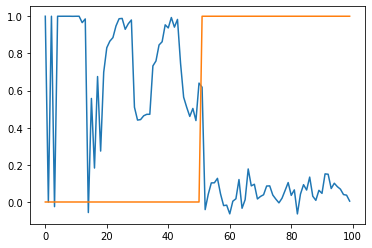

In [57]:
plt.plot(np.mean(prob_save, axis=0))
# plt.plot(prob_save.T)

plt.plot(a2_save[0,:])

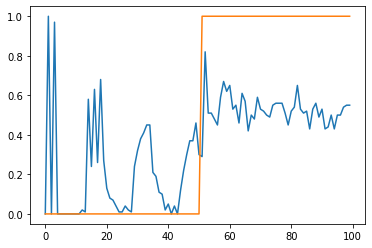

In [58]:
plt.plot(np.mean(a1_save, axis=0))
# plt.plot(a1_save.T)

plt.plot(a2_save[0,:])

In [35]:
defects = 0
for i in range(10000):
    output = agent.compute_action(np.zeros(40), full_fetch=True)
    defects += output[0]
print(output)
print(defects)

(1, [], {'action_prob': 0.566743, 'action_logp': -0.56784934, 'action_dist_inputs': array([-0.13379413,  0.13478075], dtype=float32), 'vf_preds': 6.6735945})
5697


In [92]:
tune.run(
    "PPO",
    stop={"training_iteration":10},
    config={
        "env": "MG_env",
        "num_gpus": 0,
        "num_workers": 1,
        "lr": tune.grid_search([0.01, 0.001, 0.0001]),\\
    },
    checkpoint_at_end=True
)

SyntaxError: unexpected character after line continuation character (<ipython-input-92-e294b167be59>, line 8)

In [41]:
register_env('MG_roll_env', lambda c: MatrixGameRollingHistoryEnv())

In [42]:

trainer_config_dqn = DEFAULT_CONFIG_DQN.copy()
trainer_config_dqn['num_workers'] = 3
trainer_config_dqn['n_step'] = 3
trainer_config_dqn['noisy'] = True
trainer_config_dqn['v_min'] = -10.
trainer_config_dqn['v_max'] = 10.
# trainer_config_dqn['num_atoms'] = 51

# trainer_config_dqn['model']['fcnet_hiddens'] = [1024, 512, 256,32,8]
trainer_config_dqn['model']['fcnet_hiddens'] = tune.grid_search([
    [1024, 512, 256,32,8],[256,256,32,8],[256,32]])

# trainer_config_dqn['model']['fcnet_hiddens'] = [256,256,32,8]
# trainer_config_dqn['lr'] = tune.grid_search([0.1,0.01,0.001,0.0001,0.00001, 0.000001])
trainer_config_dqn['lr'] = tune.grid_search([0.001, 0.0001, 5e-5, 1e-5])

trainer_config_dqn['env'] = 'MG_roll_env'
# trainer_config_dqn['num_cpus_per_worker'] = 0


In [43]:
# ray.init(ignore_reinit_error=True)
results = tune.run(
    "DQN",
    stop={"training_iteration":5000},
    name='test_cp',
    config=trainer_config_dqn,
#     config={
# #         "num_gpus": 0,
# #         "num_workers": 1,
# #         "lr": tune.grid_search([0.01, 0.001, 0.0001]),
#         "config":trainer_config_ppo
#     },
    verbose=1,
    checkpoint_at_end=True,
)

2021-08-14 17:06:07,724	ERROR tune.py:545 -- Trials did not complete: [DQN_MG_roll_env_52b27_00000, DQN_MG_roll_env_52b27_00001, DQN_MG_roll_env_52b27_00002, DQN_MG_roll_env_52b27_00003, DQN_MG_roll_env_52b27_00004, DQN_MG_roll_env_52b27_00005, DQN_MG_roll_env_52b27_00006, DQN_MG_roll_env_52b27_00007, DQN_MG_roll_env_52b27_00008, DQN_MG_roll_env_52b27_00009, DQN_MG_roll_env_52b27_00010, DQN_MG_roll_env_52b27_00011]
2021-08-14 17:06:07,725	INFO tune.py:549 -- Total run time: 4.62 seconds (4.24 seconds for the tuning loop).
2021-08-14 17:06:07,728	WARNING tune.py:553 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


In [28]:
print(tune.checkpoint_dir(1))

In [90]:
agent = 1

In [111]:
agent = DQNTrainer(config=trainer_config_dqn)

RayActorError: The actor died because of an error raised in its creation task, [36mray::RolloutWorker.__init__()[39m (pid=996932, ip=192.168.1.21)
  File "python/ray/_raylet.pyx", line 501, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 451, in ray._raylet.execute_task.function_executor
  File "/home/peter/.local/lib/python3.8/site-packages/ray/_private/function_manager.py", line 563, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/home/peter/.local/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 534, in __init__
    self._build_policy_map(policy_dict, policy_config)
  File "/home/peter/.local/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 1193, in _build_policy_map
    policy_map[name] = cls(obs_space, act_space, merged_conf)
  File "/home/peter/.local/lib/python3.8/site-packages/ray/rllib/policy/tf_policy_template.py", line 237, in __init__
    DynamicTFPolicy.__init__(
  File "/home/peter/.local/lib/python3.8/site-packages/ray/rllib/policy/dynamic_tf_policy.py", line 169, in __init__
    self.model = make_model(self, obs_space, action_space, config)
  File "/home/peter/.local/lib/python3.8/site-packages/ray/rllib/agents/dqn/dqn_tf_policy.py", line 167, in build_q_model
    q_model = ModelCatalog.get_model_v2(
  File "/home/peter/.local/lib/python3.8/site-packages/ray/rllib/models/catalog.py", line 612, in get_model_v2
    return wrapper(obs_space, action_space, num_outputs, model_config,
  File "/home/peter/.local/lib/python3.8/site-packages/ray/rllib/agents/dqn/distributional_q_tf_model.py", line 69, in __init__
    super(DistributionalQTFModel, self).__init__(
  File "/home/peter/.local/lib/python3.8/site-packages/ray/rllib/models/tf/fcnet.py", line 25, in __init__
    hiddens = model_config.get("fcnet_hiddens", []) + \
TypeError: unsupported operand type(s) for +: 'dict' and 'list'

In [44]:
import pickle

In [45]:
logdir = '/home/peter/ray_results/'
path = logdir + 'test_cp/DQN_MG_env_171fa_00000_0_2021-08-01_14-56-38'

# path = '/home/peter/ray_results/test_cp/DQN_MG_env_171fa_00000_0_2021-08-01_14-56-38/checkpoint_000002/checkpoint-2'

path1 = "/home/peter/ray_results/test_cp/DQN_MG_roll_env_b5628_00000_0_fcnet_hiddens=[1024, 512, 256, 32, 8]_2021-08-01_20-58-58"
cp_path = "/checkpoint_000500/checkpoint-500"

path1 = "/home/peter/ray_results/test_cp/DQN_MG_roll_env_b5628_00001_1_fcnet_hiddens=[256, 256, 32, 8]_2021-08-01_20-58-58"
cp_path = "/checkpoint_000500/checkpoint-500"

path1 = "/home/peter/ray_results/test_cp/DQN_MG_roll_env_b5628_00002_2_fcnet_hiddens=[256, 32]_2021-08-01_21-24-09"
cp_path = "/checkpoint_000500/checkpoint-500"

params_path = "/params.pkl"

In [46]:

# path1 = '/home/peter/ray_results/test_cp/PPO_MG_roll_env_0879f_00000_0_2021-08-01_21-51-24'
with open(path1 + '/params.pkl', 'rb') as f:
    data = pickle.load(f)

In [47]:
agent = DQNTrainer(config=data)

2021-08-14 17:06:26,604	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2021-08-14 17:06:31,913	INFO trainable.py:101 -- Trainable.setup took 14.240 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-08-14 17:06:31,914	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-15 09:47:45,886	WARNING worker.py:1123 -- The autoscaler failed with the following error:
Traceback (most recent call last):
  File "/home/peter/.local/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 317, in run
    self._run()
  File "/home/peter/.local/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 207, in _run
    self.update_load_metrics()
  File "/home/peter/.local/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 169, in update_l

In [46]:
agent.restore(path1+ cp_path)

2021-08-03 19:50:21,574	INFO trainable.py:377 -- Restored on 192.168.1.21 from checkpoint: /home/peter/ray_results/test_cp/DQN_MG_roll_env_b5628_00002_2_fcnet_hiddens=[256, 32]_2021-08-01_21-24-09/checkpoint_000500/checkpoint-500
2021-08-03 19:50:21,575	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 764.1960282325745, '_episodes_total': 5040}


In [34]:
defects = 0
for i in range(10000):
    output = agent.compute_action(np.array([0,1,0,0]), full_fetch=True)
    defects += output[0]
print(output)
print(defects)

2021-08-01 20:54:48,748	ERROR tf_run_builder.py:46 -- Error fetching: [<tf.Tensor 'default_policy/cond/Merge:0' shape=(?,) dtype=int64>, {'action_prob': <tf.Tensor 'default_policy/Exp:0' shape=(?,) dtype=float32>, 'action_logp': <tf.Tensor 'default_policy/zeros_like_1:0' shape=(?,) dtype=float32>, 'action_dist_inputs': <tf.Tensor 'default_policy/add_2:0' shape=(?, 2) dtype=float32>, 'q_values': <tf.Tensor 'default_policy/add_2:0' shape=(?, 2) dtype=float32>}], feed_dict={<tf.Tensor 'default_policy/obs:0' shape=(?, 40) dtype=float32>: [array([0, 1, 0, 0])], <tf.Tensor 'default_policy/is_training:0' shape=() dtype=bool>: False, <tf.Tensor 'default_policy/is_exploring:0' shape=() dtype=bool>: True, <tf.Tensor 'default_policy/timestep:0' shape=() dtype=int64>: 0}
Traceback (most recent call last):
  File "/home/peter/.local/lib/python3.8/site-packages/ray/rllib/utils/tf_run_builder.py", line 42, in get
    self._executed = run_timeline(
  File "/home/peter/.local/lib/python3.8/site-package

ValueError: Cannot feed value of shape (1, 4) for Tensor 'default_policy/obs:0', which has shape '(?, 40)'

In [59]:
en = agent.env_creator({})

In [64]:
en.observation_space

Box(0.0, 1.0, (40,), float32)

In [49]:
register_env('testenv-v0', lambda c: agent.env_creator(c))
env = gym.make('testenv-v0')

UnregisteredEnv: No registered env with id: testenv-v0

In [63]:
env1.observation_space.sample()

array([0.92038536, 0.16468304, 0.91763204, 0.93677604], dtype=float32)

In [49]:
n_eval_steps = 100
n_runs =100
# env = agent.env_creator({})
env = MatrixGameRollingHistoryEnv_2player()

state = env.reset()
a1_save = np.empty((n_runs, n_eval_steps))

a2_save = np.empty((n_runs, n_eval_steps))
for j in range(n_runs):
    state = env.reset()

    for i in range(n_eval_steps):
        a2 = int(i > 50)
        a1 = agent.compute_action(state)

        a1_save[j, i] = a1
        a2_save[j, i] = a2
        print(a1, a2)

        state, reward, done, results = env.step(a1, a2)


0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


0 0
0 0
0 0
0 0
1 0
0 0
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 1
1 1
1 1
1 1


0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 1
0 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


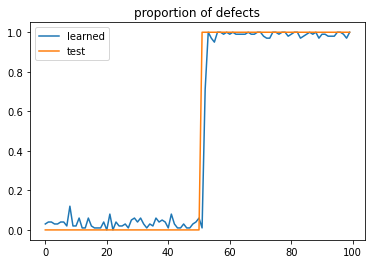

In [51]:
plt.plot(np.mean(a1_save, axis=0))
plt.plot(a2_save[0,:])
plt.title('proportion of defects')
plt.legend(['learned', 'test'])

In [101]:
a1_save

array([[0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [81]:
plt.plot()

<tf.Tensor 'default_policy/add_2:0' shape=(?, 2) dtype=float32>

In [128]:
def generate_history(n_history=100, n_turn=None):
    if n_turn is None:
        n_turn = np.random.randint(n_history)
        
    history = np.zeros((2,2,n_history))
    
    for i in range(n_turn):
        history[0, np.random.randint(2), i] = 1
        
        history[1, np.random.randint(2), i] = 1
        
    return history, n_turn

def is_t4t(agent, n_samples):
    
    agent_actions = []
    t4t_actions = []
    
    for i in range(n_samples):
        history, n_turn = generate_history
        action = agent.compute_action(history)
        if n_turn == 0:
            opponents_last_action = 0
        else:
            opponents_last_action = np.where(history[1,:,n_turn-1])
            
        agent_actions.append(action)
        t4t_actions.append(opponents_last_action)
        
    same_action = [agent_actions[i]==t4t_actions[i] for i in range(n_samples)]
    t4t_fraction = np.sum(same_action)/n_samples
    
    return t4t_fraction
    

In [107]:
np.where([1,1])

(array([0, 1]),)

In [99]:
for i in range(10):
    print(np.random.randint(2))

1
0
1
1
1
1
0
1
0
1


In [100]:
history[0, action, self._counter] = 1

import numpy as np
import torch
import matplotlib.pyplot as plt

import gym

from gym import spaces

# import axelrod


In [101]:
generate_state(n_turn=10)

array([[[0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]],

       [[1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0

In [157]:
history, n_turn = generate_history(n_history=10)

opponents_last_action = np.where(history[1,:,n_turn-1])
print(history)
print(n_turn)
print(opponents_last_action)

[[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 0. 1. 1. 1. 1. 0. 0. 0.]]

 [[0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
  [1. 1. 0. 0. 0. 0. 1. 0. 0. 0.]]]
7
(array([1]),)


In [158]:
n_turn

7

In [116]:
history[1,:,:]

array([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]])

In [49]:
h

array([[[9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]],

       [[9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 0., 0., 0., 0., 0., 0

In [86]:
aa = np.zeros((2,2,4))


In [87]:
aa

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [94]:
aa[1,np.random.randint(2,size=(4,)),:]=9

In [95]:
aa

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[9., 9., 9., 9.],
        [9., 9., 9., 9.]]])